In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import shutil
from shutil import copyfile
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import matplotlib.pyplot as plt

In [2]:
!pip install onedrivedownloader

1. Download the miniImageNet and EuroSet(RGB) dataset.

In [3]:
from onedrivedownloader import download
import gdown
# download mini-ImageNet
url = 'https://drive.usercontent.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download'
output = 'train.tar'
gdown.download(url, output, quiet=False)
# download EuroSAT_RGB
link2 = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
if not os.path.exists('./EuroSAT_RGB'):
    print('Downloading EuroSAT_RGB')
    download(link2, filename='./EuroSAT_RGB.zip', unzip=True, unzip_path='./data_final')

Downloading...
From: https://drive.usercontent.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download
To: /content/train.tar
100%|██████████| 2.42k/2.42k [00:00<00:00, 6.73MB/s]


100%|██████████| 94.7M/94.7M [00:06<00:00, 15.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 27011/27011 [00:09<00:00, 2999.71it/s]


using google colab to save the checkpoint

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


uncompress train.tar into imagenet directory, and split the data in imagenet as train, val, and test dataset at the ratio of 7:2:1

In [ ]:
class MiniImageNetGenerator(object):
    def __init__(self, tar_dir):
        self.tar_dir = tar_dir
        if self.tar_dir is not None:
            print('Untarring train.rar package')
            self.imagenet_dir = './imagenet'
            if not os.path.exists(self.imagenet_dir):
                os.mkdir(self.imagenet_dir)
            # the directory for train, val and test data
            self.processed_img_dir_train = './train'
            self.processed_img_dir_test = './test'
            self.processed_img_dir_val = './val'
            if not os.path.exists(self.processed_img_dir_train):
                os.mkdir(self.processed_img_dir_train)
            if not os.path.exists(self.processed_img_dir_test):
                os.mkdir(self.processed_img_dir_test)
            if not os.path.exists(self.processed_img_dir_val):
                os.mkdir(self.processed_img_dir_val)
            os.system('tar xvf ' + str(self.tar_dir) + ' -C ' + self.imagenet_dir)
        else:
            print('You need to specify the train.rar source file path')

    def process_original_files(self):
        train_set = []
        val_set = []
        test_set = []
        root_path = '/content/imagenet/train'

        lst = os.listdir(root_path) # your directory path
        # print(lst)
        for item in lst:
            dir_path = os.path.join(root_path, item)
            # print('dir_path:', dir_path)
            all_files = os.listdir(dir_path)
            all_files.sort()

            total_nums = len(all_files)
            train_nums = int(total_nums * 0.7)
            val_nums = int(total_nums * 0.2)
            test_nums = int(total_nums * 0.1)
            train_set = all_files[:train_nums]
            train_path = os.path.join(self.processed_img_dir_train, item)

            if not os.path.exists(train_path):
                os.mkdir(train_path)
            for idx in np.arange(len(train_set)):
                copyfile(os.path.join(dir_path, train_set[idx]),os.path.join(train_path, train_set[idx]))

            val_set = all_files[train_nums:train_nums+val_nums]
            val_path = os.path.join(self.processed_img_dir_val, item)

            if not os.path.exists(val_path):
                os.mkdir(val_path)
            for idx in np.arange(len(val_set)):
                copyfile(os.path.join(dir_path, val_set[idx]),os.path.join(val_path, val_set[idx]))

            test_set = all_files[total_nums-test_nums:]
            test_path = os.path.join(self.processed_img_dir_test, item)

            if not os.path.exists(test_path):
                os.mkdir(test_path)
            for i in np.arange(len(test_set)):
                copyfile(os.path.join(dir_path, test_set[i]),os.path.join(test_path, test_set[i]))

In [ ]:
dataset_generator = MiniImageNetGenerator('./drive/MyDrive/train.tar')
dataset_generator.process_original_files()
print('Untarring finished')

Untarring train.rar package
Untarring finished


Pretrain the ResNet-18 model base on mini-ImageNet dataset

In [ ]:
# Data augmentation and normalization for training
mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # Data augmentation, use the simplest random, left-right flipping
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('class_names:', len(class_names))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_params_path = ''

class_names: 64


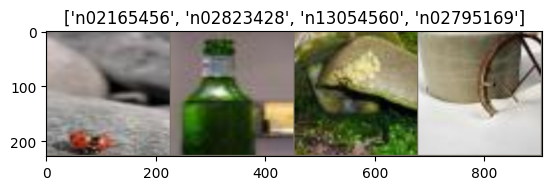

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import matplotlib.pyplot as plt
# Training the model, including scheduling the learning rate and saving the best model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model_save_name = 'classifier.pt'
    path = F"/content/drive/MyDrive/{model_save_name}"
    print('best_model_params_path:', path)
    best_acc = 0.0

    train_acc = []
    test_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training, test, and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
            if phase == 'val':
                val_acc.append(epoch_acc.cpu().numpy())
            if phase == 'test':
                test_acc.append(epoch_acc.cpu().numpy())
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.plot(epochs, test_acc, label='test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()
    # load best model weights
    model.load_state_dict(torch.load(path))
    return model

In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


best_model_params_path: /content/drive/MyDrive/classifier.pt
Epoch 0/24
----------
train Loss: 2.8930 Acc: 0.3625
val Loss: 1.6850 Acc: 0.6560
test Loss: 1.7353 Acc: 0.6299

Epoch 1/24
----------
train Loss: 1.8738 Acc: 0.5605
val Loss: 1.2490 Acc: 0.7083
test Loss: 1.3062 Acc: 0.6878

Epoch 2/24
----------
train Loss: 1.6475 Acc: 0.5866
val Loss: 1.1117 Acc: 0.7270
test Loss: 1.1769 Acc: 0.6995

Epoch 3/24
----------
train Loss: 1.5625 Acc: 0.6032
val Loss: 1.0545 Acc: 0.7299
test Loss: 1.1223 Acc: 0.7049

Epoch 4/24
----------
train Loss: 1.4913 Acc: 0.6127
val Loss: 1.0099 Acc: 0.7371
test Loss: 1.0644 Acc: 0.7154

Epoch 5/24
----------
train Loss: 1.4634 Acc: 0.6179
val Loss: 0.9833 Acc: 0.7389
test Loss: 1.0462 Acc: 0.7177

Epoch 6/24
----------
train Loss: 1.4315 Acc: 0.6254
val Loss: 0.9709 Acc: 0.7414
test Loss: 1.0289 Acc: 0.7260

Epoch 7/24
----------
train Loss: 1.3919 Acc: 0.6336
val Loss: 0.9469 Acc: 0.7516
test Loss: 1.0066 Acc: 0.7328

Epoch 8/24
----------
train Loss: 1

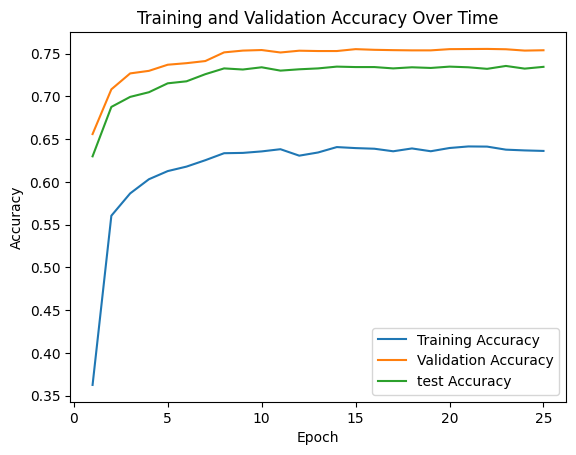

In [ ]:
# train and evaluate
pre_trained_model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
pre_trained_model.fc

Linear(in_features=512, out_features=64, bias=True)

**Reading the dataset**   

The EuroSAT dataset I use was taken from online images. This dataset based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images. However, I only choose 100 images which are from 5 different categories and each category includes 20 samples. For each category, the first 5 images belong to the train set, and the rest 15 images are in the test set.

In [6]:
class EuroSATGenerator(object):
  def __init__(self, base_dir, round = 1):
    self.base_dir = base_dir
    if (self.base_dir == None):
      print('please specify the EuroSAT source file path ')
    dir_round = './data_final/' + str(round)
    if not os.path.exists(dir_round):
      os.mkdir(dir_round)
    self.final_dir_train = os.path.join(dir_round, 'train')
    if not os.path.exists(self.final_dir_train):
      os.mkdir(self.final_dir_train)
    self.final_dir_test = os.path.join(dir_round, 'test')
    if not os.path.exists(self.final_dir_test):
      os.mkdir(self.final_dir_test)

  def process_EuroSAT_files(self, num_catagories = 5, num_train=5, num_test = 15):
    lst = os.listdir(self.base_dir)
    # print(lst)
    train_set = []
    test_set = []
    # randomly select 5 catagories
    selected_lst = random.sample(lst, num_catagories)
    # print('selected_lst:', selected_lst)
    for item in selected_lst:
      dir_path = os.path.join(self.base_dir, item)
      all_files = os.listdir(dir_path)
      # print('all_files:', all_files)
      train_set = all_files[:num_train]
      test_set = all_files[num_train: num_train + num_test]
      train_path = os.path.join(self.final_dir_train, item)
      # generate train dataset, The 25 images are from the 5 different categories. Each category includes 5 images
      if not os.path.exists(train_path):
        os.mkdir(train_path)
      for idx in np.arange(len(train_set)):
        copyfile(os.path.join(dir_path, train_set[idx]),os.path.join(train_path, train_set[idx]))
      test_path = os.path.join(self.final_dir_test, item)
      # generate test dataset, The 75 images are from the 5 different categories. Each category includes 15 images
      if not os.path.exists(test_path):
        os.mkdir(test_path)
      for idx in np.arange(len(test_set)):
        copyfile(os.path.join(dir_path, test_set[idx]),os.path.join(test_path, test_set[idx]))


In [7]:
for i in range (5):
    euro_generator = EuroSATGenerator('/content/data_final/EuroSAT_RGB', i)
    euro_generator.process_EuroSAT_files(num_catagories=5, num_train=5, num_test=15)

I create two instances to read all the image files in the training and testing datasets, respectively.    
      
During training, I first crop a random area of random size and random aspect ratio from the image, and then scale this area to a input image.       
      
During testing, we scale both the height and width of an image to 256 pixels, and then crop a central area as input. In addition, for the three RGB (red, green, and blue) color channels we standardize their values channel by channel. Concretely, the mean value of a channel is subtracted from each value of that channel and then the result is divided by the standard deviation of that channel.

In [8]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
ft_data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

I define a training function train_fine_tuning that uses fine-tuning so it can be called multiple times.     
I set the base learning rate to a small value in order to fine-tune the model parameters obtained via pretraining.

In [9]:
import matplotlib.pyplot as plt
# Training the model, including scheduling the learning rate and saving the best model
def train_fine_tuning(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_acc = 0.0

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training, test, and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in ft_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / ft_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / ft_dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
                train_loss.append(epoch_loss)
            if phase == 'test':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                test_acc.append(epoch_acc.cpu().numpy())
                test_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Testing Accuracy')
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()

    return best_acc

**Defining and Initializing the Model**       
I use ResNet-18, which was pretrained on the mini-ImageNet dataset, as the source model.

In [10]:
# Create a new ResNet-18 instance
finetune_model = models.resnet18()
finetune_model.fc = nn.Linear(finetune_model.fc.in_features, 64)
# Load the pretrained model
finetune_model.load_state_dict(torch.load('/content/drive/MyDrive/classifier.pt'))
finetune_model.fc = nn.Linear(finetune_model.fc.in_features, 5)
finetune_model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/14
----------
train Loss: 1.9074 Acc: 0.0800
test Loss: 1.5251 Acc: 0.3067

Epoch 1/14
----------
train Loss: 1.2013 Acc: 0.4400
test Loss: 1.7050 Acc: 0.2000

Epoch 2/14
----------
train Loss: 1.2426 Acc: 0.5600
test Loss: 1.6517 Acc: 0.2267

Epoch 3/14
----------
train Loss: 0.7941 Acc: 0.6800
test Loss: 1.1499 Acc: 0.5067

Epoch 4/14
----------
train Loss: 0.6933 Acc: 0.7600
test Loss: 0.9289 Acc: 0.5467

Epoch 5/14
----------
train Loss: 0.4128 Acc: 0.8800
test Loss: 0.8191 Acc: 0.6133

Epoch 6/14
----------
train Loss: 0.3785 Acc: 0.9200
test Loss: 0.8074 Acc: 0.6267

Epoch 7/14
----------
train Loss: 0.3246 Acc: 0.8400
test Loss: 0.7304 Acc: 0.6667

Epoch 8/14
----------
train Loss: 0.2772 Acc: 0.9600
test Loss: 0.6424 Acc: 0.7333

Epoch 9/14
----------
train Loss: 0.6811 Acc: 0.8000
test Loss: 0.6000 Acc: 0.7600

Epoch 10/14
----------
train Loss: 0.2898 Acc: 0.8800
test Loss: 0.5660 Acc: 0.8133

Epoch 11/14
----------
train Loss: 0.3443 Acc: 0.9600
test Loss: 0.5332 Acc

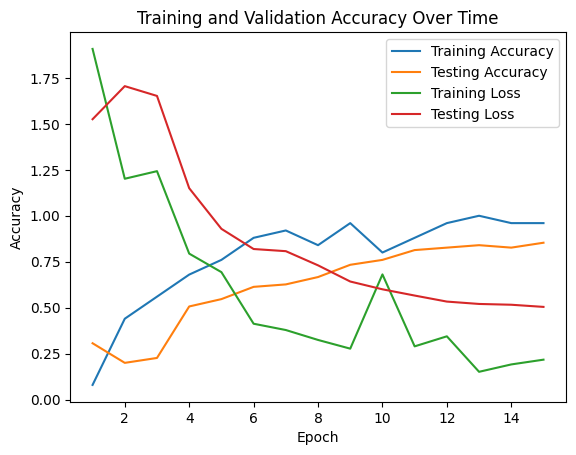

Round 1/5, best accuracy: 0.8533
Epoch 0/14
----------
train Loss: 1.8690 Acc: 0.4400
test Loss: 1.4328 Acc: 0.5467

Epoch 1/14
----------
train Loss: 1.3353 Acc: 0.5600
test Loss: 0.9526 Acc: 0.6133

Epoch 2/14
----------
train Loss: 0.7781 Acc: 0.8000
test Loss: 1.0143 Acc: 0.6133

Epoch 3/14
----------
train Loss: 0.5666 Acc: 0.8400
test Loss: 0.7800 Acc: 0.6800

Epoch 4/14
----------
train Loss: 0.3638 Acc: 0.9200
test Loss: 0.6125 Acc: 0.7867

Epoch 5/14
----------
train Loss: 0.2662 Acc: 1.0000
test Loss: 0.5854 Acc: 0.8400

Epoch 6/14
----------
train Loss: 0.4444 Acc: 0.8000
test Loss: 0.5579 Acc: 0.8267

Epoch 7/14
----------
train Loss: 0.4241 Acc: 0.8000
test Loss: 0.5374 Acc: 0.8267

Epoch 8/14
----------
train Loss: 0.3628 Acc: 0.8800
test Loss: 0.5272 Acc: 0.8400

Epoch 9/14
----------
train Loss: 0.2078 Acc: 0.9600
test Loss: 0.5177 Acc: 0.8533

Epoch 10/14
----------
train Loss: 0.2949 Acc: 0.9200
test Loss: 0.5078 Acc: 0.8533

Epoch 11/14
----------
train Loss: 0.1915 

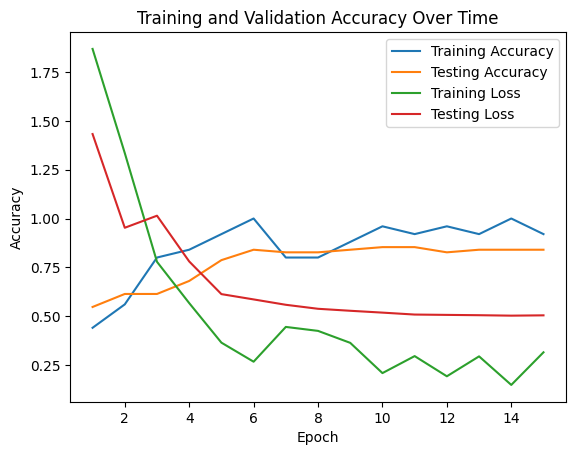

Round 2/5, best accuracy: 0.8533
Epoch 0/14
----------
train Loss: 2.9866 Acc: 0.2400
test Loss: 1.5378 Acc: 0.4267

Epoch 1/14
----------
train Loss: 1.7961 Acc: 0.3600
test Loss: 1.3102 Acc: 0.4533

Epoch 2/14
----------
train Loss: 0.7163 Acc: 0.8000
test Loss: 1.5341 Acc: 0.4000

Epoch 3/14
----------
train Loss: 0.9133 Acc: 0.7200
test Loss: 1.1852 Acc: 0.5333

Epoch 4/14
----------
train Loss: 0.3780 Acc: 0.8800
test Loss: 1.3823 Acc: 0.5467

Epoch 5/14
----------
train Loss: 0.3666 Acc: 0.8800
test Loss: 1.2208 Acc: 0.5600

Epoch 6/14
----------
train Loss: 0.2360 Acc: 0.9600
test Loss: 1.0168 Acc: 0.6400

Epoch 7/14
----------
train Loss: 0.5365 Acc: 0.8000
test Loss: 0.8796 Acc: 0.6667

Epoch 8/14
----------
train Loss: 0.3668 Acc: 0.9200
test Loss: 0.8034 Acc: 0.6933

Epoch 9/14
----------
train Loss: 0.5112 Acc: 0.8800
test Loss: 0.7711 Acc: 0.7200

Epoch 10/14
----------
train Loss: 0.3227 Acc: 0.8800
test Loss: 0.7465 Acc: 0.7600

Epoch 11/14
----------
train Loss: 0.3916 

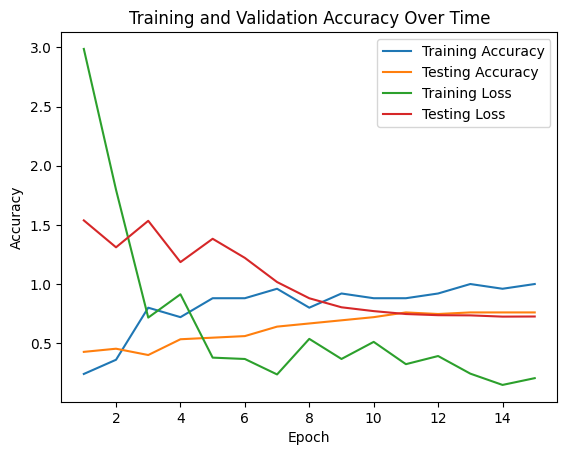

Round 3/5, best accuracy: 0.7600
Epoch 0/14
----------
train Loss: 3.8497 Acc: 0.1200
test Loss: 2.7403 Acc: 0.1200

Epoch 1/14
----------
train Loss: 1.8615 Acc: 0.3200
test Loss: 2.0835 Acc: 0.2667

Epoch 2/14
----------
train Loss: 1.0462 Acc: 0.5600
test Loss: 1.8576 Acc: 0.2667

Epoch 3/14
----------
train Loss: 0.6467 Acc: 0.7200
test Loss: 1.4239 Acc: 0.3733

Epoch 4/14
----------
train Loss: 0.6088 Acc: 0.8000
test Loss: 1.2825 Acc: 0.4267

Epoch 5/14
----------
train Loss: 0.5706 Acc: 0.7600
test Loss: 1.2574 Acc: 0.4933

Epoch 6/14
----------
train Loss: 0.5800 Acc: 0.8000
test Loss: 1.2526 Acc: 0.5333

Epoch 7/14
----------
train Loss: 0.5693 Acc: 0.8800
test Loss: 1.2474 Acc: 0.6000

Epoch 8/14
----------
train Loss: 0.3736 Acc: 0.8800
test Loss: 1.2746 Acc: 0.5333

Epoch 9/14
----------
train Loss: 0.4409 Acc: 0.8800
test Loss: 1.3072 Acc: 0.5467

Epoch 10/14
----------
train Loss: 0.3415 Acc: 0.9200
test Loss: 1.3228 Acc: 0.5333

Epoch 11/14
----------
train Loss: 0.2837 

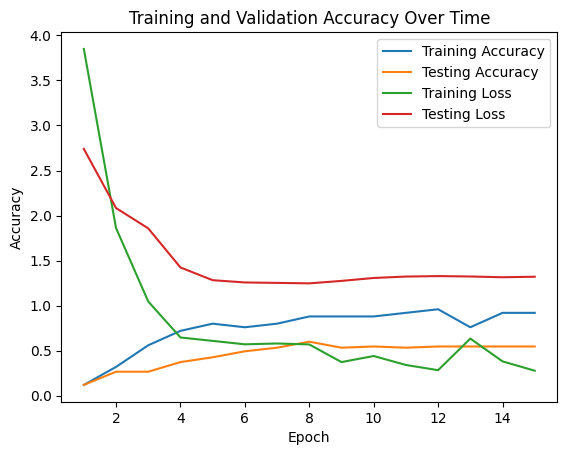

Round 4/5, best accuracy: 0.6000
Epoch 0/14
----------
train Loss: 2.3731 Acc: 0.1600
test Loss: 1.8297 Acc: 0.2667

Epoch 1/14
----------
train Loss: 1.0572 Acc: 0.5200
test Loss: 1.5439 Acc: 0.4133

Epoch 2/14
----------
train Loss: 0.8230 Acc: 0.7200
test Loss: 1.3812 Acc: 0.4667

Epoch 3/14
----------
train Loss: 0.7269 Acc: 0.7600
test Loss: 1.3160 Acc: 0.5200

Epoch 4/14
----------
train Loss: 0.7945 Acc: 0.8800
test Loss: 1.2887 Acc: 0.5733

Epoch 5/14
----------
train Loss: 0.5197 Acc: 0.8000
test Loss: 1.2851 Acc: 0.4667

Epoch 6/14
----------
train Loss: 0.3382 Acc: 0.8800
test Loss: 1.3163 Acc: 0.4533

Epoch 7/14
----------
train Loss: 0.4519 Acc: 0.8400
test Loss: 1.3591 Acc: 0.4400

Epoch 8/14
----------
train Loss: 0.4249 Acc: 0.8800
test Loss: 1.3914 Acc: 0.4400

Epoch 9/14
----------
train Loss: 0.5271 Acc: 0.8800
test Loss: 1.4104 Acc: 0.4933

Epoch 10/14
----------
train Loss: 0.5171 Acc: 0.8400
test Loss: 1.3833 Acc: 0.5200

Epoch 11/14
----------
train Loss: 0.2267 

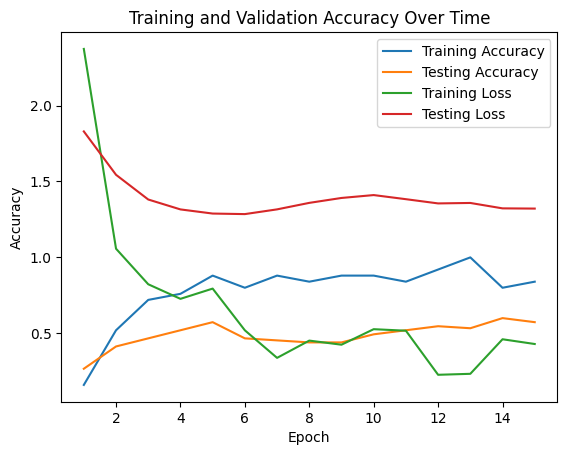

Round 5/5, best accuracy: 0.6000
after 5 round training, avg_acc: 0.7333


In [11]:
round = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = 0.0
for i in range(round):
    data_dir = os.path.join('/content/data_final', str(i))
    EuroSAT_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          ft_data_transforms[x])
                  for x in ['train', 'test']}
    ft_dataloaders = {x: torch.utils.data.DataLoader(EuroSAT_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
    ft_dataset_sizes = {x: len(EuroSAT_datasets[x]) for x in ['train', 'test']}
    ft_class_names = EuroSAT_datasets['train'].classes
    for param in finetune_model.parameters():
        param.requires_grad = True
    finetune_model = finetune_model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(finetune_model.parameters(), lr=0.005, momentum=0.9)


    # Decay LR by a factor of 0.1 every 5 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
    best_acc = train_fine_tuning(finetune_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)
    print(f'Round {i+1}/{round}, best accuracy: {best_acc:.4f}')
    total += best_acc
avg_acc = total / round
print(f'after {round} round training, avg_acc: {avg_acc:.4f}')

I use the hymenooptera dataset as a comprison. Hymenooptera dataset download from pytorch official tutorial.

In [ ]:
link='https://download.pytorch.org/tutorial/hymenoptera_data.zip'

if not os.path.exists('./hymenoptera_data'):
    print('Downloading hymenoptera_data')
    download(link, filename='./hymenoptera_data.zip', unzip=True, unzip_path='./')

100%|██████████| 47.3M/47.3M [00:00<00:00, 60.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 405/405 [00:00<00:00, 1386.17it/s]


In [ ]:
import matplotlib.pyplot as plt
# Training the model, including scheduling the learning rate and saving the best model
def train_fine_tuning_test(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_acc = 0.0

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training, test, and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in hd_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / hd_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / hd_dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
                train_loss.append(epoch_loss)
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                test_acc.append(epoch_acc.cpu().numpy())
                test_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()

    return best_acc

In [ ]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
hd_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
hd_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          hd_data_transforms[x])
                  for x in ['train', 'val']}
hd_dataloaders = {x: torch.utils.data.DataLoader(hd_image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
hd_dataset_sizes = {x: len(hd_image_datasets[x]) for x in ['train', 'val']}
class_names = hd_image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create a new ResNet-18 instance
ft_model = models.resnet18()
ft_model.fc = nn.Linear(ft_model.fc.in_features, 64)
# Load the pretrained model
ft_model.load_state_dict(torch.load('/content/drive/MyDrive/classifier.pt'))
ft_model.fc = nn.Linear(ft_model.fc.in_features, 5)
ft_model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/24
----------
train Loss: 0.0444 Acc: 0.9918
val Loss: 0.1723 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.0297 Acc: 0.9918
val Loss: 0.2057 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0285 Acc: 0.9959
val Loss: 0.1722 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.0357 Acc: 1.0000
val Loss: 0.2277 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.0283 Acc: 0.9959
val Loss: 0.2092 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.0216 Acc: 1.0000
val Loss: 0.2277 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.0342 Acc: 0.9918
val Loss: 0.2125 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.0367 Acc: 0.9877
val Loss: 0.2034 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0412 Acc: 0.9918
val Loss: 0.2331 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.0283 Acc: 1.0000
val Loss: 0.2078 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0175 Acc: 1.0000
val Loss: 0.1870 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0150 Acc: 1.0000
val Loss: 0.1921 Acc: 0.9412

Ep

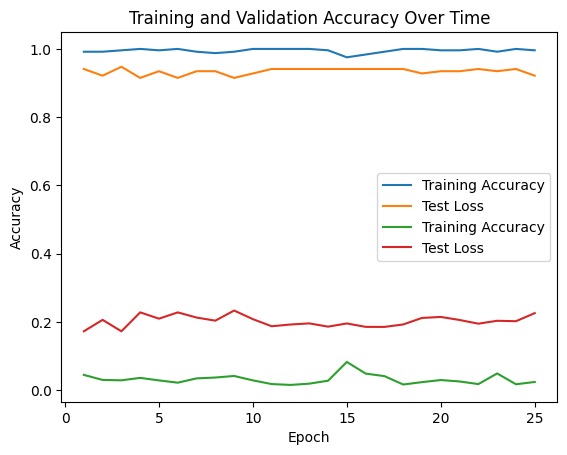

In [ ]:
for param in ft_model.parameters():
  param.requires_grad = True

ft_model.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(ft_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_fine_tuning_test(ft_model, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25)